In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Functions adapted from https://github.com/transientskp/tkp/blob/master/tkp/utility/sigmaclip.py

def clip(data, mean, sigma):
    """Performs sigma clipping of data around mean.
    
    Parameters
    ----------
    data numpy.ndarray: 
        Array of values.
    mean: float
        Value around which to clip (does not have to be the mean).
    sigma: float
        Sigma-value for clipping.
        
    Returns
    -------
    indices: numpy.ndarray
        Indices of non-clipped data.
    """
    ilow = data >= mean - sigma
    ihigh = data <= mean + sigma
    indices = np.logical_and(ilow, ihigh)
    
    return indices


def calc_sigma(data, errors=None):
    """Calculates the weighted standard deviation.
    
    Parameters
    ----------
    data: numpy.ndarray
        Data to be averaged.
    errors: numpy.ndarray, default 'None'
        Errors for the data. If 'None', unweighted
        values are calculated.
        
    Returns
    -------
    wmean: numpy.ndarray
        Weighted mean.
    wsigma: numpy.ndarray
        Weighted standard deviation.
    """
    if errors is None:
        w = 1.0
    else:
        w = 1.0/errors**2
        wmean = np.average(data, weights=w)
    
    V1 = w.sum()
    V2 = (w**2).sum()
    # weighted sample variance
    wsigma = np.sqrt(((data - wmean) * (data - wmean)*w).sum() *
                        (V1 / (V1*V1 - V2)))

    return wmean, wsigma


def weighted_sigmaclip(data, errors=None, niter=1, n_sigma=3, 
                       use_median=False):
    """Remove outliers from data which lie more than n_sigma
    standard deviations from mean.
    
    Parameters
    ----------
    data: numpy.ndarray
        Array containing data values.
    errors: numpy.ndarray, default 'None'
        Errors associated with the data. If 'None', unweighted mean 
        and standard deviation are used in calculations.
    niter: int, default '1' 
        Number of iterations to calculate mean and standard
        deviation, and reject outliers, If niter is negative,
        iterations will continue until no more clipping occurs or
        until abs('niter') is reached, whichever is reached first.
    n_sigma: float, default '3' 
        Number of standard deviations used for sigma clipping.
    use_median: bool, default 'False':
        If 'True', use median of data instead of mean.
        
    Returns
    -------
    indices: boolan numpy.array
        Boolean numpy array of indices indicating which
        elements are clipped (False), with the same shape as the
        input
    i: int
        Number of iterations
    """
    # indices keeps track which data should be discarded
    indices = np.ones(len(data.ravel()), 
                         dtype=np.bool).reshape(data.shape)
    
    if niter < 0:
        nniter = -niter
    else:
        nniter = niter
    
    for i in range(nniter):
        newdata = data[indices]
        if errors is None:
            newerrors = None
        else:
            newerrors = errors[indices]
        
        N = len(newdata)
        if N < 2:
            # no data left to clip
            return indices, i

        mean, sigma = calc_sigma(newdata, newerrors)
        if use_median:
            mean = np.median(newdata)
        newindices = clip(data, mean, n_sigma*sigma)
        
        if niter < 0:
            # break when no changes
            if (newindices == indices).all():
                break
        indices = newindices
        
    return indices, i + 1

In [44]:
def weighted_rolling(x_data, y_data, yerr_data=None, 
                     window=3, center=False,
                    sigma_clip=False, **sigclip_kwargs):
    """Weighted rolling functions, similar to pandas
    rolling function.
    
    Parameters
    ----------
    x_data: array
        X-axis data.
    y_data: array
        Y-axis data.
    yerr_data: array
        Y-axis error.
    window: float
        Time window in the same units as 'x'.
    center: bool, default 'False'
        If 'False', set the window labels as the right 
        edge of the window index. If 'True', set the window 
        labels as the center of the window index.
        
    Returns
    -------
    rolling_y: array
        Rolling data.
    """
    rolling_dict = {'x':[], 'y':[], 'yerr':[]}
    if yerr_data is None:
        yerr_data = np.ones_like(y_data) 
    
    x_used = np.empty(0)
    for i, x in enumerate(x_data):
        # window type
        if center==True:
            roll_x = x_data.copy() 
            roll_y = y_data.copy()
            roll_yerr = yerr_data.copy()
            mask = np.abs(x-roll_x)<=window/2
        else:
            roll_x = x_data[:i+1].copy()
            roll_y = y_data[:i+1].copy()
            roll_yerr = yerr_data[:i+1].copy()
            mask = x-roll_x<=window
            
        roll_x = roll_x[mask]
        roll_y = roll_y[mask]
        roll_yerr = roll_yerr[mask]
        
        # if only one or no data point is left, 
        # no need to do anything else
        if len(roll_x)==0:
            continue
        elif len(roll_x)==1:
            rolling_dict['x'].append(roll_x[0])
            rolling_dict['y'].append(roll_y[0])
            rolling_dict['yerr'].append(roll_yerr[0])
            continue
            
        # sigma clipping within rolling segments 
        if sigma_clip:
            if 'errors' in sigclip_kwargs.keys():
                errors = sigclip_kwargs['errors']
                sigclip_kwargs.pop('errors')
            else:
                errors = roll_x
            mask, n_iter =  weighted_sigmaclip(roll_y, 
                                               errors, 
                                               **sigclip_kwargs)
            roll_x = roll_x[mask]
            roll_y = roll_y[mask]
            roll_yerr = roll_yerr[mask]
            
            if len(roll_x)==0:
                continue
            
        # keep track of the values being used
        x_used = np.r_[x_used, roll_x]    
        
        # calculate weighted mean and error propagation
        # x-axis
        rolling_dict['x'].append(roll_x.mean())
        # y-axis
        w = 1/roll_yerr**2
        wmean = np.average(roll_y, weights=w)
        rolling_dict['y'].append(wmean)
        # y-error: standard deviation of the weighted mean
        wstd = np.sqrt(1/np.sum(w))
        rolling_dict['yerr'].append(wstd)
        
    # turn lists into arrays    
    for key, values in rolling_dict.items():
        rolling_dict[key] = np.array(rolling_dict[key])
        
    # values used
    indices = np.array([True if x in x_used else False for x in x_data])
    
    return rolling_dict['x'], rolling_dict['y'], rolling_dict['yerr'], indices

In [45]:
def flux2mag(flux, zp, flux_err=0.0):
    """Converts fluxes to magnitudes, propagating errors if given.
    Note: if there are negative or zero fluxes, these are converted to NaN values.
    Parameters
    ----------
    flux : array
        Array of fluxes.
    zp : float or array
        Zero points.
    flux_err : array, default ``0.0``
        Array of flux errors.
    Returns
    -------
    mag : array
        Fluxes converted to magnitudes.
    mag_err : array
        Flux errors converted to errors in magnitudes.
    """

    if type(flux)==np.ndarray:
        flux_ = np.array([f if f>=0.0 else np.nan for f in flux ])  # turns negative and 0.0 values to NaN
    elif flux<=0.0:
        flux_ = np.nan
    else:
        flux_ = flux
        
    mag = -2.5*np.log10(flux_) + zp
    mag_err = np.abs( 2.5*flux_err/(flux_*np.log(10)) )

    return mag, mag_err

def mag2flux(mag, zp, mag_err=0.0):
    """Converts magnitudes to fluxes, propagating errors if given.
    Parameters
    ----------
    mag : array
        Array of magnitudes.
    zp : float or array
        Zero points.
    mag_err : array, default ``0.0``
        Array of magnitude errors.
    Returns
    -------
    flux : array
        Magnitudes converted to fluxes.
    flux_err : array
        Magnitude errors converted to errors in fluxes.
    """

    flux = 10**( -0.4*(mag-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*mag_err )

    return flux, 

In [46]:
class lightcurve(object):
    """Light curve class.
    """
    def __init__(self, band, lcs_df):
        """
        Parameters
        ----------
        band: str
            ATLAS band (o or c).
        lcs_df: DataFrame
            ATLAS forced photometry.
        """
        self.band = band

        data = lcs_df[lcs_df.F == band]
        self.time = data.MJD.values
        self.flux = data.uJy.values
        self.flux_err = data.duJy.values
        self.mag = data.m.values
        self.mag_err = data.dm.values
        color_dict = {'c':'cyan', 'o':'orange'}
        self.color = color_dict[band]
        self.snr = data.uJy.values/data.duJy.values
        self.zp = 23.9

    def __repr__(self):
        return f'band: {self.band}'

    def __getitem__(self, item):
        return getattr(self, item)
    
    def mask_lc(self, mask):
        """Masks the light curve with the given mask.
        
        Parameters
        ----------
        mask: booleans
            Mask with the same length as the light curves.
        """
        self.time = self.time.copy()[mask]
        self.flux = self.flux.copy()[mask]
        self.flux_err = self.flux_err.copy()[mask]
        self.mag = self.mag.copy()[mask]
        self.mag_err = self.mag_err.copy()[mask]
        self.snr = self.snr.copy()[mask]
        
    def sigma_clip(self, niter=1, n_sigma=3, use_median=False):
        """
        """
        indices, iter_val = weighted_sigmaclip(self.flux, self.flux_err, 
                                             niter, n_sigma, use_median)
        self.time = self.time[indices]
        self.flux = self.flux[indices]
        self.flux_err = self.flux_err[indices]
        self.mag = self.mag[indices]
        self.mag_err = self.mag_err[indices]
        self.indices = indices
        self.iter = iter_val
        
    def rolling(self, window, center=False, 
                sigma_clip=False, **sigclip_kwargs):
        """
        """
        x, y, yerr, inds = weighted_rolling(self.time, self.flux, 
                                     self.flux_err, window, center, 
                                      sigma_clip, **sigclip_kwargs)
        self.time = x
        self.flux = y
        self.flux_err = yerr
        self.mag, self.mag_err = flux2mag(y, self.zp, yerr)
        self.indices = inds

class lightcurves(object):
    """Multi-colour light curves class.
    """
    def __init__(self, lcs_df):
        """
        Parameters
        ----------
        lcs_df: DataFrame
            ATLAS forced photometry.
        """
        self.bands = lcs_df.F.unique()

        for band in self.bands:
            lc = lightcurve(band, lcs_df)
            setattr(self, band, lc)

    def __repr__(self):
        return str(self.bands)

    def __getitem__(self, item):
        return getattr(self, item)

In [47]:
class atlas_object(object):
    
    def __init__(self, lc_file):
        """
        """
        self.lc_file = lc_file
        lc_df = pd.read_csv(lc_file)
        self.lc_df = lc_df
        self.lcs = lightcurves(lc_df)
        self.init_lcs = deepcopy(self.lcs)
        self.bands = lc_df.F.unique()
        self.modified = False
        
    def __repr__(self):
        rep = (f'LC file: {self.lc_file}')
        return rep
    
    def __getitem__(self, item):
        return getattr(self, item)
    
    def plot_original(self, xmin=None, xmax=None):
        """
        """
        mags = np.empty(0)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        for filt in self.bands:
            init_lcs = self.init_lcs[filt]
            ax.errorbar(init_lcs.time, init_lcs.mag, init_lcs.mag_err, 
                        fmt='o', label=filt, c=init_lcs.color, mec='k')
            mags = np.r_[mags, init_lcs.mag]

        ax.set_ylabel('Appartent Magnitude', fontsize=18)
        ax.set_xlabel('MJD', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_ylim(mags.min()-0.5, mags.max()+0.5)
        ax.set_xlim(xmin, xmax)
        ax.invert_yaxis()
        ax.legend(fontsize=18)
        plt.show()
        
    def plot_lcs(self, xmin=None, xmax=None):
        """
        """
        mags = np.empty(0)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        for filt in self.bands:
            if self.modified:
                lcs = self.lcs[filt]
                ax.errorbar(lcs.time, lcs.mag, lcs.mag_err, 
                        fmt='*', c=lcs.color)
                alpha = 0.2
            else:
                alpha = 1
            
            init_lcs = self.init_lcs[filt]
            ax.errorbar(init_lcs.time, init_lcs.mag, init_lcs.mag_err, 
                        fmt='o', label=filt, c=init_lcs.color, mec='k',
                        alpha=alpha)
            mags = np.r_[mags, init_lcs.mag]

        ax.set_ylabel('Appartent Magnitude', fontsize=18)
        ax.set_xlabel('MJD', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.set_ylim(mags.min()-0.5, mags.max()+0.5)
        ax.set_xlim(xmin, xmax)
        ax.invert_yaxis()
        ax.legend(fontsize=18)
        plt.show()
        
    def rolling(self, window, center=False, 
                sigma_clip=False, **sigclip_kwargs):
        """
        """
        color_dict = {'c':'blue', 'o':'red'}
        for filt in self.bands:
            self.lcs[filt].rolling(window, center, 
                                   sigma_clip, 
                                   **sigclip_kwargs)
            self.lcs[filt].color = color_dict[filt]
        self.modified = True
            
    def sigma_clip(self, niter=0, n_sigma=3, use_median=False):
        """
        """
        color_dict = {'c':'blue', 'o':'red'}
        for filt in self.bands:
            self.lcs[filt].sigma_clip(niter, n_sigma, use_median)
            self.lcs[filt].color = color_dict[filt]
        self.modified = True

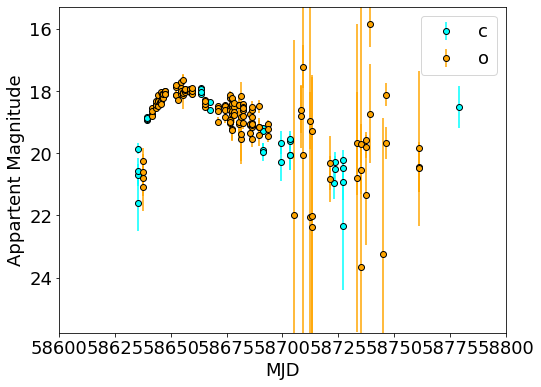

In [53]:
lc_file = 'test_lc.csv'
obj = atlas_object(lc_file)
obj.plot_lcs(58600, 58800)

/tmp/ipykernel_57473/2804364287.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool).reshape(data.shape)
/tmp/ipykernel_57473/4086535066.py:27: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5*np.log10(flux_) + zp
/tmp/ipykernel_57473/4086535066.py:28: RuntimeWarning: divide by zero encountered in true_divide
  mag_err = np.abs( 2.5*flux_err/(flux_*np.log(10)) )


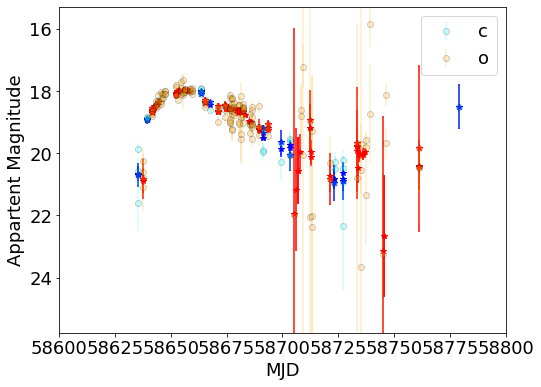

In [57]:
sigclip_kwargs = {
    'n_sigma':1
                 }
obj.rolling(3, center=False, sigma_clip=True, **sigclip_kwargs)
#obj.sigma_clip(3)
obj.plot_lcs(58600, 58800)

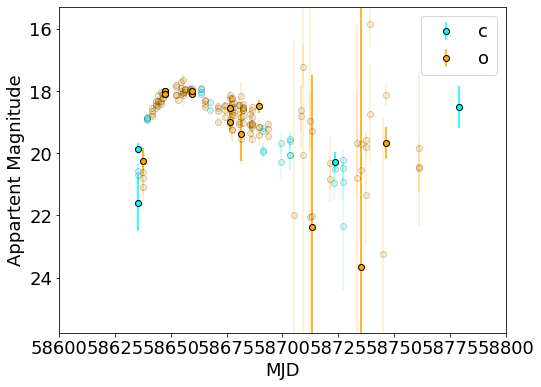

In [58]:
mags = np.empty(0)

fig, ax = plt.subplots(figsize=(8, 6))
for filt in 'co':
    lc = obj.init_lcs[filt]
    time = lc.time
    mag = lc.mag
    mag_err = lc.mag_err
    mask = ~obj.lcs[filt].indices
    ax.errorbar(time, mag, mag_err, 
                fmt='o', c=lc.color, mec='k',
                alpha=0.2)
    ax.errorbar(time[mask], mag[mask], mag_err[mask], 
                fmt='o', label=filt, c=lc.color, mec='k'
               )
    mags = np.r_[mags, mag]

ax.set_ylabel('Appartent Magnitude', fontsize=18)
ax.set_xlabel('MJD', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(mags.min()-0.5, mags.max()+0.5)
ax.set_xlim(58600, 58800)
ax.invert_yaxis()
ax.legend(fontsize=18)
plt.show()